# Setup and references

In [1]:
## IMPORT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
results_dir = r"#" #location to save to

In [3]:
extensPath = r"#" #filepath for extensometry data (CSV)

In [4]:
dic_dir = r"#" #directory for DIC data files (CSV)

# Read extensometry, identify start/end of test

In [5]:
df1 = pd.read_csv(extensPath, delimiter = ';', skiprows = range(0,2), names = ['DIC Image Index', 'Load [N]'], usecols = [4,5])

In [6]:
# IDENTIFY START AND END OF TEST (CRITERIA USE CHANGE IN LOAD)
load_list = df1['Load [N]'].tolist()
load_change = []
for i in range(len(load_list)):
	if i == 0:
		change = 0
	elif i != 0:
		change = load_list[i] - load_list[i-1]
	load_change.append(change)
df1['load change']=load_change

# Start of test: (First dL>2 index)-1 index
df_temp = df1.drop(df1[df1['load change'] <2].index)
start_index = df_temp.index[0] - 1
start_image = start_index+1

# End of test: (First dl<-50 index)-1 index
df_temp = df1.drop(df1[df1['load change'] > -50].index)
end_index = df_temp.index[0] - 1
end_image = end_index+1

df2=df1
indexDrop = list(range(0,start_index,1)) + list(range(end_index+1,len(df2.index),1))
df2 = df2.drop(indexDrop) # Trim data to start of test
df2 = df2.drop(axis=1, labels=['load change'])

In [7]:
df2

DIC Image Index    Load [N]
129              130   21.252318
130              131   23.399059
131              132   25.671848
132              133   28.057262
133              134   30.512148
..               ...         ...
819              820  481.886250
820              821  479.151120
821              822  476.965170
822              823  475.034210
823              824  471.975670

[695 rows x 2 columns]

# Read DIC data

In [8]:
# ESTABLISH DIC DATA FILE NAMES
extens_last = len(df1.index)
if extens_last < 1000:
	dicNames = []
	for i in range(start_image, end_image+1, 1):
		if i < 10:
			i_name = '00'+str(i)
		elif 10 <= i < 100:
			i_name = '0'+str(i)
		elif 100 <= i < 1000:
			i_name = str(i)
		dicNames.append(i_name)
elif extens_last >= 1000:
	dicNames = []
	for i in range(start_image, end_image+1, 1):
		if i < 10:
			i_name = '000'+str(i)
		elif 10 <= i < 100:
			i_name = '00'+str(i)
		elif 100 <= i < 1000:
			i_name = '0'+str(i)
		elif 1000 <= i < 10000:
			i_name = str(i)
		dicNames.append(i_name)
elif extens_last >= 10000:
	exit()

dicFiles = []
for dicName in dicNames:
	dicFile = str(dic_dir + '/data_' + dicName + '.csv')
	dicFiles.append(dicFile)

## Read strain data

In [9]:
# READ DIC DATA AT CENTRAL POINT (BETWEEN NOTCHES) WITH SPATIAL AVERAGING
#x_av_range, y_av_range = interest_area() #User input removed in Rev6
x_av_range, y_av_range = 3,1

strain_av_list = []
print('Strain data being read from CSV files, please wait... ')
for dicFile in dicFiles:
	data =  pd.read_csv(dicFile, skiprows=1, encoding = 'latin1', names=['xc','yc','zc','strain'], usecols = [0,1,2,19])
	##Discarding data for all X co-ordinates outside region of interest
	x = data['xc'].tolist()
	x_min = min(x)
	x_max = max(x)
	x_mid = ((x_max - x_min)/2) + x_min
	x_u = list(set(x))
	x_u.sort()
	x_u_mid = min(x_u, key=lambda x:abs(x-x_mid))
	x_base = x_u.index(x_u_mid)

	x_range_interest = int((x_av_range/2) - 0.5)
	x_interest = []
	for i in range(-x_range_interest,x_range_interest+1):
		x_i = x_u[x_base+i]
		x_interest.append(x_i)
	
	data_drop = data[data['xc'].isin(x_interest) == False].index
	data2 = data.drop(data_drop)
	#Now have a dataframe with all x co-ordinates of interest, but many y co-ordinates beyond interest
	
	##Extracting Y of interest
	drop_hi = data[data['yc'] > 6].index #Note, working from the original dataset again
	data3 = data.drop(drop_hi)
	drop_lo = data[data['yc'] < -2].index
	data3 = data3.drop(drop_lo)

	y = data3['yc'].tolist()
	y_u = list(set(y))
	y_u.sort()

	x_list = []
	for y in y_u:
		x_sub_list=[]
		y_indexes = list(data3[data3['yc'] == y].index)
		for i in y_indexes:
			x = data.at[i,'xc']
			x_sub_list.append(x)
		x_list.append(x_sub_list) #This is a list of all the x-coordinates at that y co-ordinate

	x_length = []
	for i in x_list:
		x_length.append(len(i)) #For each y co-ordinate, these are the x co-ordinates

	x_len_min = min(x_length)
	x_len_min_index = []
	for i in range(len(x_length)):
		if x_length[i] == x_len_min:
			x_len_min_index.append(i)
	x_mid_index = int(round((x_len_min_index[-1] + x_len_min_index[0])/2,0))
	y_base_val = y_u[x_mid_index] #This is the y value for the notch root
	y_base = y_u.index(y_base_val)
	
	y_range_interest = int((y_av_range/2) - 0.5)
	y_interest = []
	for i in range(-y_range_interest,y_range_interest+1):
		y_i = y_u[y_base+i]
		y_interest.append(y_i)

	data2_drop = data2[data2['yc'].isin(y_interest) == False].index
	data4 = data2.drop(data2_drop)
	#Now have a dataframe with all x and y co-ordinates of interest
	
	##Mean average (spatial) of strain values
	strains = data4['strain'].tolist()
	av_strain = round(sum(strains)/len(strains),6)

	strain_av_list.append(av_strain)
	print('read '+dicFile)
	
df3 = df2
df3['Mean True Strain [-]'] = strain_av_list
print("Strain data has been read from files.")

Strain data being read from CSV files, please wait... 
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_130.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_131.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_132.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_133.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_134.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_135.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_136.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_137.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_138.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_139.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/d

read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_224.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_225.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_226.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_227.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_228.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_229.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_230.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_231.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_232.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_233.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_234.csv
read E:\MEng-CCFE-data\Testing2019\dataExpo

read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_320.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_321.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_322.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_323.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_324.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_325.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_326.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_327.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_328.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_329.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_330.csv
read E:\MEng-CCFE-data\Testing2019\dataExpo

read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_416.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_417.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_418.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_419.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_420.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_421.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_422.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_423.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_424.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_425.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_426.csv
read E:\MEng-CCFE-data\Testing2019\dataExpo

read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_512.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_513.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_514.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_515.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_516.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_517.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_518.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_519.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_520.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_521.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_522.csv
read E:\MEng-CCFE-data\Testing2019\dataExpo

read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_608.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_609.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_610.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_611.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_612.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_613.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_614.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_615.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_616.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_617.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_618.csv
read E:\MEng-CCFE-data\Testing2019\dataExpo

read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_704.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_705.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_706.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_707.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_708.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_709.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_710.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_711.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_712.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_713.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_714.csv
read E:\MEng-CCFE-data\Testing2019\dataExpo

read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_800.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_801.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_802.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_803.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_804.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_805.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_806.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_807.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_808.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_809.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_810.csv
read E:\MEng-CCFE-data\Testing2019\dataExpo

## Read displacement data

In [10]:
#FIND CO-ORDINATES FOR DISPLACEMENT MEASUREMENT
data =  pd.read_csv(dicFiles[0], skiprows=1, encoding = 'latin1', names=['xc','yc','zc','strain'], usecols = [0,1,2,19])

# Find x reference point (between notches)
x = data['xc'].tolist()
x_min = min(x)
x_max = max(x)
x_mid = ((x_max - x_min)/2) + x_min
x_u = list(set(x))
x_u.sort()
x_u_mid = min(x_u, key=lambda x:abs(x-x_mid))
x_base = x_u.index(x_u_mid)

# find y reference point (between notches)
drop_hi = data[data['yc'] > 6].index #Note, working from the original dataset again
data3 = data.drop(drop_hi)
drop_lo = data[data['yc'] < -2].index
data3 = data3.drop(drop_lo)

y = data3['yc'].tolist()
y_u = list(set(y))
y_u.sort()

x_list = []
for y in y_u:
    x_sub_list=[]
    y_indexes = list(data3[data3['yc'] == y].index)
    for i in y_indexes:
        x = data.at[i,'xc']
        x_sub_list.append(x)
    x_list.append(x_sub_list) #This is a list of all the x-coordinates at that y co-ordinate

x_length = []
for i in x_list:
    x_length.append(len(i)) #For each y co-ordinate, these are the x co-ordinates

x_len_min = min(x_length)
x_len_min_index = []
for i in range(len(x_length)):
    if x_length[i] == x_len_min:
        x_len_min_index.append(i)
x_mid_index = int(round((x_len_min_index[-1] + x_len_min_index[0])/2,0))
y_base_val = y_u[x_mid_index] #This is the y value for the notch root
y_base = y_u.index(y_base_val)

x = x_u_mid
y1 = y_base_val - 5
y2 = y_base_val + 5
x, y1, y2

(3.4764160000000004, -2.97653, 7.02347)

In [11]:
# Read displacement from DIC files
print('Displacement data being read from CSV files, please wait... ')
d1_list = []
d2_list = []
for dicFile in dicFiles:
    data =  pd.read_csv(dicFile, skiprows=1, encoding = 'latin1', names=['xc','yc','yd'], usecols = [0,1,4])
    # Get index for (x1,y1)
    temp_df = data.iloc[(data['xc'] - x).abs().argsort()[:1]]
    temp_df.reset_index(inplace=True)
    x_ref = temp_df.at[0,'xc']

    data1 = data.drop(data[data['xc'] != x_ref].index)
    temp_df = data1.iloc[(data1['yc'] - y1).abs().argsort()[:1]]
    temp_df.reset_index(inplace=True)
    y1_ref = temp_df.at[0, 'yc']

    temp_df = data.drop(data[data['xc'] != x_ref].index.tolist())
    temp_df = temp_df.drop(temp_df[temp_df['yc'] != y1_ref].index.tolist())
    index1 = temp_df.index.values[0]

    # Get index for (x2,y2)
    data1 = data.drop(data[data['xc'] != x_ref].index)
    temp_df = data1.iloc[(data1['yc'] - y2).abs().argsort()[:1]]
    temp_df.reset_index(inplace=True)
    y2_ref = temp_df.at[0, 'yc']

    temp_df = data.drop(data[data['xc'] != x_ref].index.tolist())
    temp_df = temp_df.drop(temp_df[temp_df['yc'] != y2_ref].index.tolist())
    index2 = temp_df.index.values[0]

    # Displacements
    d1 = data.at[index1, 'yd']
    d2 = data.at[index2, 'yd']
    d1_list.append(d1)
    d2_list.append(d2)
    print('read '+dicFile)

Displacement data being read from CSV files, please wait... 
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_130.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_131.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_132.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_133.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_134.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_135.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_136.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_137.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_138.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_139.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dic

read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_225.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_226.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_227.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_228.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_229.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_230.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_231.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_232.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_233.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_234.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_235.csv
read E:\MEng-CCFE-data\Testing2019\dataExpo

read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_322.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_323.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_324.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_325.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_326.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_327.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_328.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_329.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_330.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_331.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_332.csv
read E:\MEng-CCFE-data\Testing2019\dataExpo

read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_417.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_418.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_419.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_420.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_421.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_422.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_423.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_424.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_425.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_426.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_427.csv
read E:\MEng-CCFE-data\Testing2019\dataExpo

read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_513.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_514.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_515.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_516.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_517.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_518.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_519.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_520.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_521.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_522.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_523.csv
read E:\MEng-CCFE-data\Testing2019\dataExpo

read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_611.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_612.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_613.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_614.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_615.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_616.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_617.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_618.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_619.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_620.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_621.csv
read E:\MEng-CCFE-data\Testing2019\dataExpo

read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_708.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_709.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_710.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_711.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_712.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_713.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_714.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_715.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_716.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_717.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_718.csv
read E:\MEng-CCFE-data\Testing2019\dataExpo

read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_803.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_804.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_805.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_806.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_807.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_808.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_809.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_810.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_811.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_812.csv
read E:\MEng-CCFE-data\Testing2019\dataExport\sn08_failure_sumDif\dicData/data_813.csv
read E:\MEng-CCFE-data\Testing2019\dataExpo

In [12]:
d_list = []
for i in range(len(d1_list)):
    d = d2_list[i] - d1_list[i]
    d_list.append(d)
df3['Displacement [mm]'] = d_list

In [13]:
# REMOVE POINTS WITH NEGATIVE DISPLACEMENT
df3 = df3.drop(df3[df3['Displacement [mm]'] < 0].index)
df3 = df3.reset_index(drop=True)

In [14]:
df3

DIC Image Index    Load [N]  Mean True Strain [-]  Displacement [mm]
0                130   21.252318              0.001989           0.000364
1                131   23.399059              0.001534           0.000287
2                132   25.671848              0.001250           0.000413
3                133   28.057262              0.001901           0.000572
4                134   30.512148              0.001725           0.000711
..               ...         ...                   ...                ...
690              820  481.886250              0.740547           0.437881
691              821  479.151120              0.751492           0.438905
692              822  476.965170              0.758873           0.439830
693              823  475.034210              0.763329           0.440908
694              824  471.975670              0.770577           0.441914

[695 rows x 4 columns]

# Informative plots

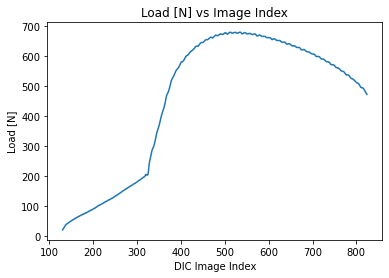

In [15]:
# PLOT LOAD VS DIC IMAGE
plot0 = plt.figure()
ax = plot0.add_subplot(1,1,1)
ax.plot(df3['DIC Image Index'], df3['Load [N]']) # label = ''
ax.set_xlabel('DIC Image Index')
ax.set_ylabel('Load [N]')
ax.set_title('Load [N] vs Image Index')
plot0_path = (results_dir+'/0_Load-Image.png')
plot0.savefig(plot0_path)

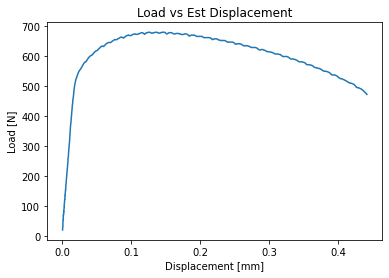

In [16]:
# PLOT EST DISPLACEMENT VS LOAD
plot1 = plt.figure()
ax = plot1.add_subplot(1,1,1)
ax.plot(df3['Displacement [mm]'], df3['Load [N]']) # label = ''
ax.set_xlabel('Displacement [mm]')
ax.set_ylabel('Load [N]')
ax.set_title('Load vs Est Displacement')
plot1_path = (results_dir+'/1_Load-EstDisp.png')
plot1.savefig(plot1_path)

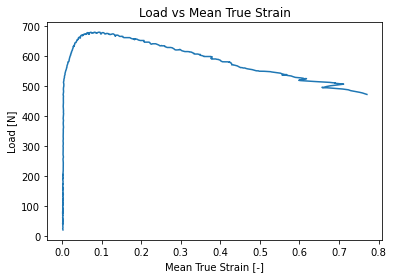

In [17]:
#  PLOT TRUE STRAIN VS LOAD
plot2 = plt.figure()
ax = plot2.add_subplot(1,1,1)
ax.plot(df3['Mean True Strain [-]'], df3['Load [N]']) # label = ''
ax.set_xlabel('Mean True Strain [-]')
ax.set_ylabel('Load [N]')
ax.set_title('Load vs Mean True Strain')
plot2_path = (results_dir+'/2_Load-MeanTrueStrain.png')
plot2.savefig(plot2_path)

# Condition data for input to iterative process

## Remove points where strain decreases

In [18]:
# REMOVE POINTS WHERE STRAIN DECREASES
df4 = df3
# Calculate row-to-row strain changes
df4['strain diff'] = df4['Mean True Strain [-]'].diff(1)

# Check if OK
strain_diffs = df4['strain diff'].tolist()
if any(x < 0 for x in strain_diffs):
    strain_check = 'bad'
else:
    strain_check = 'good'

while strain_check == 'bad':
    # Remove any rows with negative change
    df4 = df4.drop(df4[df4['strain diff'] < 0].index)
    # Delete row-to-row strain change column
    df4 = df4.drop(axis=1, labels=['strain diff'])
    # Calculate row-to-row strain changes again
    df4['strain diff'] = df4['Mean True Strain [-]'].diff(1)    
    # Check if OK
    strain_diffs = df4['strain diff'].tolist()
    if any(x < 0 for x in strain_diffs):
        strain_check = 'bad'
    else:
        strain_check = 'good'
df4 = df4.drop(axis=1, labels=['strain diff'])
df4 = df4.reset_index(drop=True)

## Change displacement to m

In [19]:
disp_map = lambda x: x/1000
df4['Est Displacement [m]'] = df4['Displacement [mm]'].map(disp_map)
df4 = df4.drop(labels='Displacement [mm]', axis=1)

In [20]:
df4

DIC Image Index    Load [N]  Mean True Strain [-]  Est Displacement [m]
0                130   21.252318              0.001989          3.637566e-07
1                138   38.991487              0.002363          8.016129e-07
2                155   55.433086              0.002443          1.165000e-06
3                195   86.753198              0.002448          2.270000e-06
4                215  104.517370              0.002500          2.839000e-06
..               ...         ...                   ...                   ...
373              820  481.886250              0.740547          4.378810e-04
374              821  479.151120              0.751492          4.389050e-04
375              822  476.965170              0.758873          4.398300e-04
376              823  475.034210              0.763329          4.409080e-04
377              824  471.975670              0.770577          4.419140e-04

[378 rows x 4 columns]

In [21]:
df4 = df4.drop(axis=1, labels=['DIC Image Index'])

## Estimate stress, make yield row, drop rows before yield

In [22]:
K = 1000e6 #Estimate from preliminary analyses
n = 0.13 #Estimate from preliminary analyses
stress_est = lambda e: K*(e**n)
df4['Hollomon Guess [Pa]'] = df4['Mean True Strain [-]'].map(stress_est)

In [23]:
yield_strength = 377.53e6 #493.9e6
elastic_modulus = 208.66e9
Area = 9e-7

In [24]:
# INSERT YIELD ROW, NEEDED TO CALCULATE PLASTIC STRAIN
yield_strain = yield_strength/elastic_modulus #Equivalent uniaxial yield strain
est_yield_load = yield_strength * Area
temp_data = {'Load [N]':est_yield_load, 'Mean True Strain [-]':yield_strain, 'Est Displacement [m]':np.NaN , 'Hollomon Guess [Pa]':yield_strength}
df4 = df4.append(temp_data, ignore_index=True)
#Drop rows less than yield, sort, renumber
df4 = df4.drop(df4[df4['Load [N]'] < est_yield_load].index)
df4.sort_values(by=['Mean True Strain [-]'], inplace=True)
df4 = df4.reset_index(drop=True)

In [25]:
df4

Load [N]  Mean True Strain [-]  Est Displacement [m]  \
0    339.77700              0.001809                   NaN   
1    362.45712              0.003282              0.000012   
2    408.46838              0.003441              0.000014   
3    479.91477              0.003444              0.000017   
4    499.98014              0.004076              0.000018   
..         ...                   ...                   ...   
367  481.88625              0.740547              0.000438   
368  479.15112              0.751492              0.000439   
369  476.96517              0.758873              0.000440   
370  475.03421              0.763329              0.000441   
371  471.97567              0.770577              0.000442   

     Hollomon Guess [Pa]  
0           3.775300e+08  
1           4.754425e+08  
2           4.783756e+08  
3           4.784298e+08  
4           4.890243e+08  
..                   ...  
367         9.617049e+08  
368         9.635409e+08  
369         9.647660e+08  
370         9.655006e+08  
371         9.666875e+08  

[372 rows x 4 columns]

## Calculate plastic strain

In [26]:
# PLASTIC STRAIN (FOR MULTILINEAR PLASTICITY MODEL IN ANSYS)
df4_strain = df4['Mean True Strain [-]'].tolist()
plas_strain = []
for i in range(len(df4_strain)):
    if i == 0:
        plas = 0
    elif i != 0:
        plas = df4_strain[i]-df4_strain[0]
    plas_strain.append(plas)
df4['Plastic Strain (True) [-]'] = plas_strain

# Remove any points that are very close to yield (not computationally efficient)
if any(1e-10 < x < 1e-3 for x in plas_strain):
    plas_strain_drop = df4[(df4['Plastic Strain (True) [-]'] < 1e-3) & (df4['Plastic Strain (True) [-]'] > 1e-10)].index
    df4 = df4.drop(plas_strain_drop)
    df4.reset_index(inplace=True)
    df4 = df4.drop(labels='index',axis=1)
else:
    pass

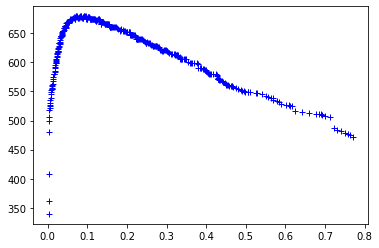

In [27]:
plt.plot(df4['Mean True Strain [-]'], df4['Load [N]'], 'b+')

## Select sampling points

In [28]:
len(df4.index)

372

In [29]:
df5 = df4

In [30]:
drop_ind = []
for i in df5.index.values:
    if i == 0:
        pass
    elif i == (len(df5.index.values)-1):
        pass
    elif i%7 != 0:
        drop_ind.append(i)
df5 = df5.drop(drop_ind)

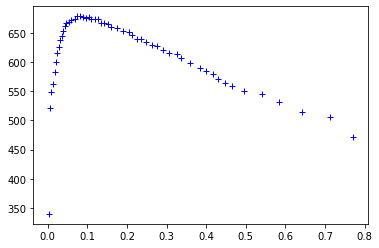

In [31]:
plt.plot(df5['Mean True Strain [-]'], df5['Load [N]'], 'b+')

In [32]:
len(df5.index)

54

In [33]:
df5

Load [N]  Mean True Strain [-]  Est Displacement [m]  \
0    339.77700              0.001809                   NaN   
7    521.53965              0.004278              0.000020   
14   548.42629              0.008158              0.000024   
21   562.62299              0.011960              0.000028   
28   583.03545              0.017163              0.000035   
35   600.77278              0.020862              0.000041   
42   615.84865              0.024135              0.000048   
49   625.95501              0.027276              0.000054   
56   638.00787              0.031558              0.000063   
63   644.52704              0.034892              0.000070   
70   654.09211              0.037902              0.000076   
77   662.25699              0.042963              0.000084   
84   666.94204              0.046760              0.000093   
91   669.11641              0.052759              0.000101   
98   671.89286              0.059649              0.000109   
105  673.28542              0.067713              0.000119   
112  678.47913              0.072935              0.000127   
119  678.67306              0.081244              0.000135   
126  677.37155              0.089367              0.000142   
133  675.42874              0.096952              0.000150   
140  677.46207              0.103335              0.000157   
147  673.31226              0.110280              0.000164   
154  673.24911              0.117970              0.000171   
161  673.24595              0.126544              0.000177   
168  666.37101              0.134888              0.000184   
175  667.73279              0.142169              0.000193   
182  664.96950              0.150990              0.000199   
189  660.92127              0.158329              0.000208   
196  658.14061              0.174538              0.000216   
203  654.11553              0.191008              0.000226   
210  651.36803              0.206019              0.000234   
217  645.88881              0.213661              0.000243   
224  639.10992              0.225479              0.000251   
231  640.46881              0.236428              0.000258   
238  633.68334              0.249213              0.000265   
245  629.50774              0.263266              0.000273   
252  628.11386              0.274559              0.000280   
259  619.94688              0.290484              0.000287   
266  615.87496              0.306604              0.000296   
273  613.11851              0.325932              0.000302   
280  606.30278              0.335139              0.000310   
287  598.59077              0.358728              0.000319   
294  589.86197              0.383754              0.000333   
301  584.39328              0.400453              0.000341   
308  580.41242              0.418053              0.000347   
315  570.86392              0.430072              0.000357   
322  563.99003              0.446700              0.000365   
329  558.49160              0.464220              0.000371   
336  550.34067              0.496496              0.000379   
343  544.84803              0.539764              0.000387   
350  531.19157              0.583446              0.000400   
357  514.74287              0.640815              0.000413   
364  506.20643              0.711671              0.000422   
371  471.97567              0.770577              0.000442   

     Hollomon Guess [Pa]  Plastic Strain (True) [-]  
0           3.775300e+08                   0.000000  
7           4.921090e+08                   0.002469  
14          5.351874e+08                   0.006349  
21          5.624774e+08                   0.010151  
28          5.895181e+08                   0.015354  
35          6.046670e+08                   0.019053  
42          6.162319e+08                   0.022326  
49          6.261112e+08                   0.025467  
56          6.380934e+08                   0.029749  
63          6.464789e+08                   0.033083  
7

In [34]:
# MANUALLY SELECT POINTS TO DROP FROM DATASET
todrop = [126, 154, 189, 252]
df5 = df5.drop(todrop)
df5 = df5.reset_index(drop=True)

In [35]:
len(df5.index)

50

In [36]:
df5

Load [N]  Mean True Strain [-]  Est Displacement [m]  \
0   339.77700              0.001809                   NaN   
1   521.53965              0.004278              0.000020   
2   548.42629              0.008158              0.000024   
3   562.62299              0.011960              0.000028   
4   583.03545              0.017163              0.000035   
5   600.77278              0.020862              0.000041   
6   615.84865              0.024135              0.000048   
7   625.95501              0.027276              0.000054   
8   638.00787              0.031558              0.000063   
9   644.52704              0.034892              0.000070   
10  654.09211              0.037902              0.000076   
11  662.25699              0.042963              0.000084   
12  666.94204              0.046760              0.000093   
13  669.11641              0.052759              0.000101   
14  671.89286              0.059649              0.000109   
15  673.28542              0.067713              0.000119   
16  678.47913              0.072935              0.000127   
17  678.67306              0.081244              0.000135   
18  675.42874              0.096952              0.000150   
19  677.46207              0.103335              0.000157   
20  673.31226              0.110280              0.000164   
21  673.24595              0.126544              0.000177   
22  666.37101              0.134888              0.000184   
23  667.73279              0.142169              0.000193   
24  664.96950              0.150990              0.000199   
25  658.14061              0.174538              0.000216   
26  654.11553              0.191008              0.000226   
27  651.36803              0.206019              0.000234   
28  645.88881              0.213661              0.000243   
29  639.10992              0.225479              0.000251   
30  640.46881              0.236428              0.000258   
31  633.68334              0.249213              0.000265   
32  629.50774              0.263266              0.000273   
33  619.94688              0.290484              0.000287   
34  615.87496              0.306604              0.000296   
35  613.11851              0.325932              0.000302   
36  606.30278              0.335139              0.000310   
37  598.59077              0.358728              0.000319   
38  589.86197              0.383754              0.000333   
39  584.39328              0.400453              0.000341   
40  580.41242              0.418053              0.000347   
41  570.86392              0.430072              0.000357   
42  563.99003              0.446700              0.000365   
43  558.49160              0.464220              0.000371   
44  550.34067              0.496496              0.000379   
45  544.84803              0.539764              0.000387   
46  531.19157              0.583446              0.000400   
47  514.74287              0.640815              0.000413   
48  506.20643              0.711671              0.000422   
49  471.97567              0.770577              0.000442   

    Hollomon Guess [Pa]  Plastic Strain (True) [-]  
0          3.775300e+08                   0.000000  
1          4.921090e+08                   0.002469  
2          5.351874e+08                   0.006349  
3          5.624774e+08                   0.010151  
4          5.895181e+08                   0.015354  
5          6.046670e+08                   0.019053  
6          6.162319e+08                   0.022326  
7          6.261112e+08                   0.025467  
8          6.380934e+08                   0.029749  
9          6.464789e+08                   0.033083  
10         6.534706e+08                   0.036093  
11         6.642052e+08                   0.041154  
12         6.715582e+08                   0.044951  
13         6.821793e+08                   0.050950  
14         6.931519e+08                   0.057840  
15         7.046726e+08                   0.0

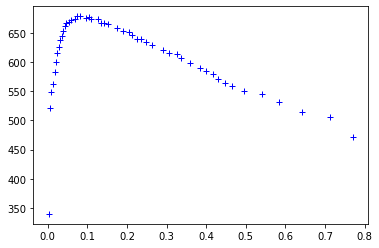

In [37]:
plt.plot(df5['Mean True Strain [-]'], df5['Load [N]'], 'b+')

## Plot sampling points on original data for comparison

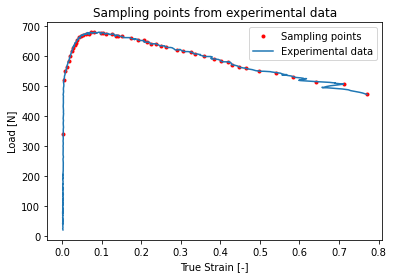

In [38]:
# PLOT SAMPLING POINTS AGAINST ORIGINAL DATA
plot4 = plt.figure()
ax = plot4.add_subplot(1,1,1)
ax.plot(df5['Mean True Strain [-]'], df5['Load [N]'],'r.',label='Sampling points')
ax.plot(df2['Mean True Strain [-]'], df2['Load [N]'], label = 'Experimental data')
ax.legend()
ax.set_xlabel('True Strain [-]')
ax.set_ylabel('Load [N]')
ax.set_title('Sampling points from experimental data')
plot4_path = (results_dir+'/4_SamplingPoints.png')
plot4.savefig(plot4_path)

# Export to CSV

In [39]:
cols = list(df5.columns.values)
cols

['Load [N]',
 'Mean True Strain [-]',
 'Est Displacement [m]',
 'Hollomon Guess [Pa]',
 'Plastic Strain (True) [-]']

In [40]:
cols = ['Mean True Strain [-]', 'Plastic Strain (True) [-]', 'Load [N]', 'Hollomon Guess [Pa]', 'Est Displacement [m]']
df5 = df5[cols]
df5

Mean True Strain [-]  Plastic Strain (True) [-]   Load [N]  \
0               0.001809                   0.000000  339.77700   
1               0.004278                   0.002469  521.53965   
2               0.008158                   0.006349  548.42629   
3               0.011960                   0.010151  562.62299   
4               0.017163                   0.015354  583.03545   
5               0.020862                   0.019053  600.77278   
6               0.024135                   0.022326  615.84865   
7               0.027276                   0.025467  625.95501   
8               0.031558                   0.029749  638.00787   
9               0.034892                   0.033083  644.52704   
10              0.037902                   0.036093  654.09211   
11              0.042963                   0.041154  662.25699   
12              0.046760                   0.044951  666.94204   
13              0.052759                   0.050950  669.11641   
14              0.059649                   0.057840  671.89286   
15              0.067713                   0.065904  673.28542   
16              0.072935                   0.071126  678.47913   
17              0.081244                   0.079435  678.67306   
18              0.096952                   0.095143  675.42874   
19              0.103335                   0.101526  677.46207   
20              0.110280                   0.108471  673.31226   
21              0.126544                   0.124735  673.24595   
22              0.134888                   0.133079  666.37101   
23              0.142169                   0.140360  667.73279   
24              0.150990                   0.149181  664.96950   
25              0.174538                   0.172729  658.14061   
26              0.191008                   0.189199  654.11553   
27              0.206019                   0.204210  651.36803   
28              0.213661                   0.211852  645.88881   
29              0.225479                   0.223670  639.10992   
30              0.236428                   0.234619  640.46881   
31              0.249213                   0.247404  633.68334   
32              0.263266                   0.261457  629.50774   
33              0.290484                   0.288675  619.94688   
34              0.306604                   0.304795  615.87496   
35              0.325932                   0.324123  613.11851   
36              0.335139                   0.333330  606.30278   
37              0.358728                   0.356919  598.59077   
38              0.383754                   0.381945  589.86197   
39              0.400453                   0.398644  584.39328   
40              0.418053                   0.416244  580.41242   
41              0.430072                   0.428263  570.86392   
42              0.446700                   0.444891  563.99003   
43              0.464220                   0.462411  558.49160   
44              0.496496                   0.494687  550.34067   
45              0.539764                   0.537955  544.84803   
46              0.583446                   0.581637  531.19157   
47              0.640815                   0.639006  514.74287   
48              0.711671                   0.709862  506.20643   
49              0.770577                   0.768768  471.97567   

    Hollomon Guess [Pa]  Est Displacement [m]  
0          3.775300e+08                   NaN  
1          4.921090e+08              0.000020  
2          5.351874e+08              0.000024  
3          5.624774e+08              0.000028  
4          5.895181e+08              0.000035  
5          6.046670e+08              0.000041  
6          6.162319e+08              0.000048  
7          6.261112e+08              0.000054  
8          6.380934e+08              0.000063  
9          6.464789e+08              0.000070  
10         6.534706e+08              0.000076  
11         6.642052e+08              0.000084  
12         6.

In [41]:
df_output_csv_path=(results_dir+"/input_data.csv")
df5.to_csv(df_output_csv_path, index=True, header=True)